In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.datasets import co2, sunspots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf

In questa lezione, vedremo l'applicazione delle tecniche illustrate durante la parte teorica per la modellazione delle serie temporali, con particolare riferimento alla *decomposizione STL* ed alla modellazione mediante *ARIMA*.

## Parte 1: Decomposizione STL

Iniziamo parlando della decomposizione STL. Utilizzeremo i dati presenti nel dataset `co2`, contenuto nel package `datasets` di `statsmodels`.

Questi dati sono relativi all'andamento stimato dei livelli di CO2 nel corso degli anni. Carichiamoli usando il metodo `load_pandas()`, e selezionando la struttura `data`.

In [2]:
df = co2.load_pandas().data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Notiamo che ci sono più dati per ciascuna mensilità. Dato che vogliamo fare in modo da avere un singolo campione per ogni mese considerato, usiamo la funzione [`resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html), specificando come regola il ricampionamento sul singolo mese (il parametro da inserire è `'M'`).

Per ricampionare i valori, useremo la media (funzione [`mean`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.resample.Resampler.mean.html?highlight=mean#pandas.core.resample.Resampler.mean)). In questo caso, poi, andiamo anche ad assegnare i valori mancanti (NaN) nella serie temporale usando la modalità `ffill`, che assegna ad ogni NaN il valore valido immediatamente precedente. 

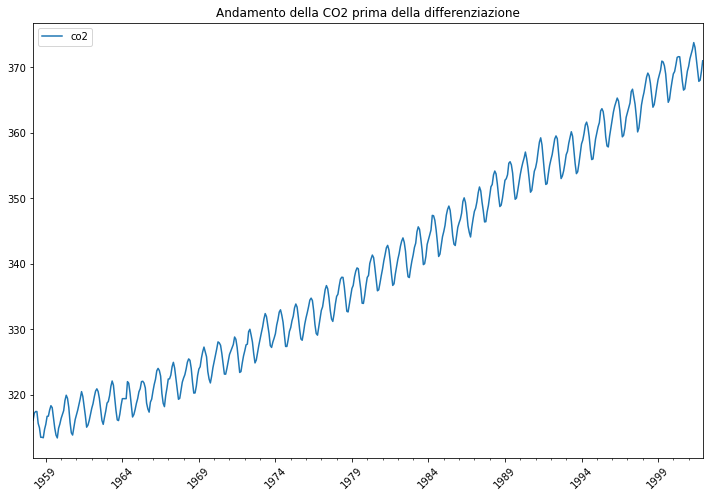

In [3]:
df = df.resample('M').mean().ffill()
df.plot(
    title='Andamento della CO2 prima della differenziazione', rot=45, figsize=(12,8))
plt.show()

A questo punto, possiamo effettuare la decomposizione STL della nostra serie temporale mediante il metodo [`STL`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html).

Dato che abbiamo a disposizione un dataframe Pandas nel quale gli indici sono le date di rilevamento del valore della CO2, StatsModels sarà in grado di inferire automaticamente il periodo e la stagionalità dei dati. Se avessimo avuto un semplice array NumPy, avremmo dovuto specificare manualmente questi parametri.

> **Nota**: specificare manualmente la stagionalità richiede uno studio della modalità con cui si ripetono i pattern nel tempo: di conseguenza, occorre visualizzare la serie, ed inferire, anche grazie ad un esperto di dominio, il periodo legato alla stagionalità ed ad eventuali cicli.

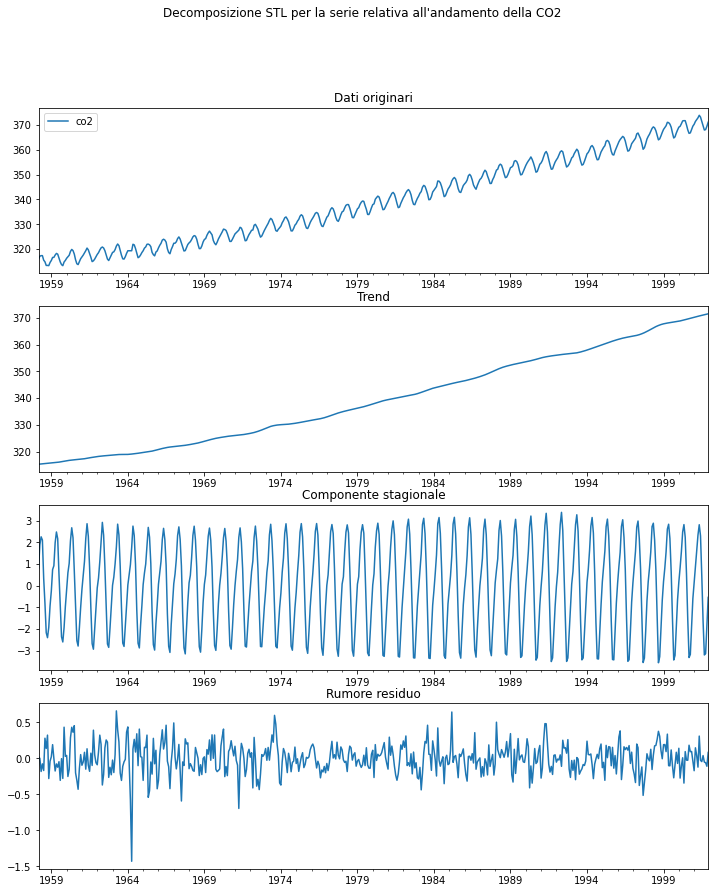

In [4]:
stl = STL(df)
res = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 14))
df.plot(ax=axes[0])
axes[0].set_title('Dati originari')
res.trend.plot(ax=axes[1])
axes[1].set_title('Trend')
res.seasonal.plot(ax=axes[2])
axes[2].set_title('Componente stagionale')
res.resid.plot(ax=axes[3])
axes[3].set_title('Rumore residuo')
plt.suptitle('Decomposizione STL per la serie relativa all\'andamento della CO2')
plt.show()

## Parte 2: modellazione con ARIMA

In questa seconda parte, utilizzeremo un modello ARIMA per modellare il dataset `sunspots`, rappresentativo della presenza di macchie solari sulla superficie del sole.

Iniziamo caricando il dataset, ed impostando come indice l'anno di rilevamento.

In [5]:
df = sunspots.load_pandas().data
df.set_index('YEAR', inplace=True)
df.head()

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0


Visualizziamo i dati.

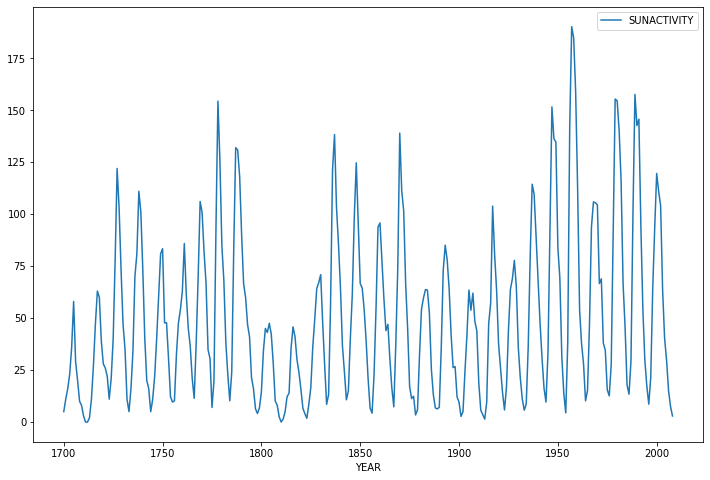

In [6]:
df.plot(figsize=(12, 8))
plt.show()

### Parte 2.1: determinare gli ordini AR, I ed MA

Per determinare gli ordini da utilizzare nel modello, possiamo usare due metodi:

1. effettuare un approccio *trial & error*, basandoci sui valori assunti da alcune metriche;
2. usare le funzioni di autocorrelazione (ACF) ed autocorrelazione parziale (PACF).

Nel primo caso, dovremo basarci sui valori assunti dalle metriche `AIC`, `BIC` ed `HQIC`, stanti rispettivamente per *Akaike Information Criterion*, *Bayesian Information Criterion* ed *Hannan-Quinn Information Criterion*. Trovate una buona descrizione [a questo link](https://www.lorenzogovoni.com/selezione-del-modello-aic-bic-hqic/); tuttavia, basta sapere che, tra due modelli, si sceglie quello con i valori di AIC, BIC ed HQIC inferiori.

Nel secondo caso, invece, potremo fare uno studio qualitativo dell'andamento delle funzioni ACF e PACF, che ci aiuterà ad avere delle indicazioni sugli ordini da utilizzare. Proviamo ad usare il secondo aprroccio.

#### Parte 2.1.1: la funzione di autocorrelazione (ACF)

La *funzione di autocorrelazione* ci restituisce il valore di correlazione della serie temporale con se stessa negli istanti precedenti.

In pratica, se $\rho(x, y)$ è l'indice di correlazione di due serie $x$ ed $y$, allora la funzione di correlazione avrà come primo valore $\rho(y(t), y(t))$, come secondo valore $\rho(y(t), y(t-1))$, e così via.

Appare evidente come un alto valore della funzione di autocorrelazione per un istante $t-i$ indichi un'alta dipendenza del valore assunto dalla serie $y$ all'istante $t$ da quello assunto dalla stessa all'istante $t-i$, e che quindi questo possa essere usato per avere un'indicazione sull'ordine AR da ricercare sul modello.

Per visualizzare la funzione ACF, usiamo il metodo [`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html).

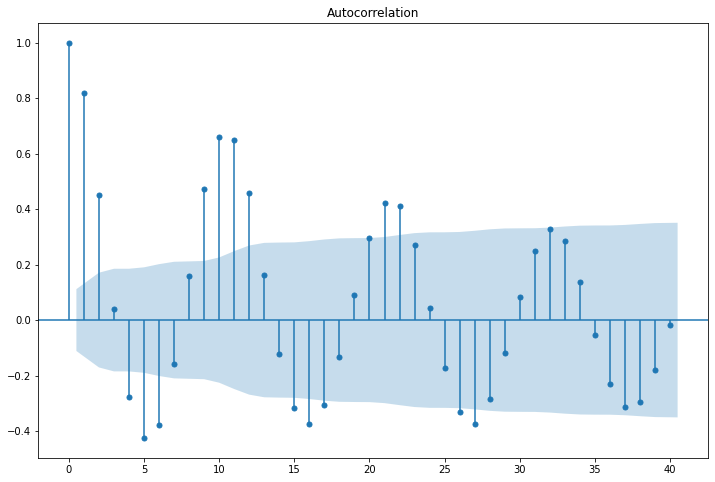

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax)
plt.show()

Se la serie fosse stazionaria, vedremmo ogni linea all'interno dell'intervallo di confidenza segnato in blu. 

Tuttavia, vediamo dei picchi e delle valli al di fuori di questo intervallo, ed un andamento veloce e decadente che ricorda un grafo. Questo indica che c'è una stagionalità, ma probabilmente non abbiamo alcun trend.

| Velocità decadimento | Similitudine ad un seno | Presenza trend | Presenza stagionalità |
| -------------------- | ----------------------- | -------------- | --------------------- |
| Lenta                | Sì                      | Sì             | Sì                    |
| Lenta                | No                      | Sì             | No                    |
| Rapida               | Sì                      | No             | Sì                    |

Sulla base alla tabella precedente, possiamo supporre che vi sia una stagionalità, ma non un trend. Di conseguenza, l'impatto della parte MA dovrebbe essere giocoforza limitato sulle prestazioni del modello.

### Parte 2.1.2: la funzione di autocorrelazione parziale (PACF)

La funzione di autocorrelazione parziale individua la correlazione tra le componenti *residue* ed i valori assunti dalla serie negli istanti precedenti.

Questo indica quindi la possibilità di modellare la presenza di una relazione tra i valori passati della serie temporale ed i residui nell'istante attuale, il che si sposa perfettamente con l'idea alla base dei processo MA.

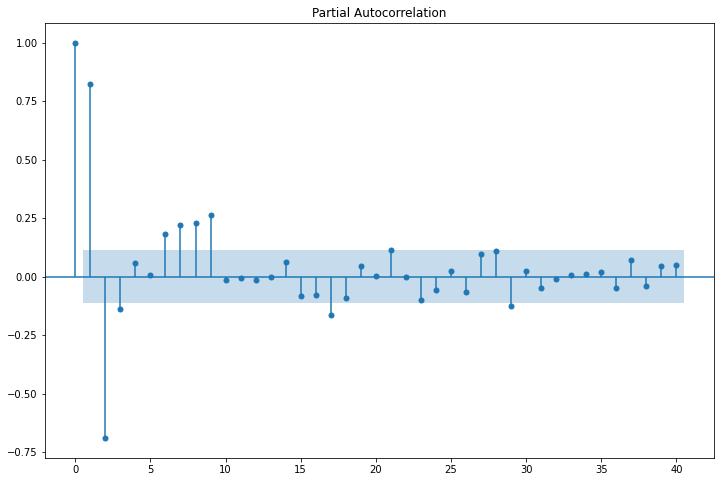

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax)
plt.show()

Quello che ci interessa individuare nella PACF sono i picchi e le valli che sono *significativamente* oltre l'intervallo di confidenza. In questo caso, ne notiamo due, ovvero quelli in posizione 1 e 2.

Dall'analisi delle funzioni ACF e PACF, abbiamo quindi la possibilità di dedurre i seguenti valori per gli ordini dei processi della serie:

* per il processo AR, l'ordine supposto è pari a 2;
* per il processo MA, l'ordine supposto è pari a 2;
* per il processo I, non vi è alcun ordine supposto, in quanto dall'ACF sembra non ci siano trend evidenti (il che è confermato anche dal plot della serie).

Proviamo quindi ad usare un ARIMA di ordine (2, 0, 2).

In [9]:
model = ARIMA(df, order=(2, 0, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1304.436
Date:                Mon, 26 Jul 2021   AIC                           2620.873
Time:                        10:09:43   BIC                           2643.273
Sample:                             0   HQIC                          2629.828
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7502      3.667     13.567      0.000      42.563      56.938
ar.L1          1.4460      0.077     18.755      0.000       1.295       1.597
ar.L2         -0.7458      0.064    -11.681      0.000      -0.871      -0.621
ma.L1         -0.1405      0.097     -1.447      0.148      -0.331       0.050
ma.L2          0.0691      0.079      0.874      0.382      -0.086       0.224
sigma2       269.5971     18.567     14.520      0.000     233.207     305.988
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               102.49
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.91
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Proviamo a visualizzare l'andamento dei valori predetti (ottenuti con il metodo `predict()`), confrontandoli con quello dei valori veri.

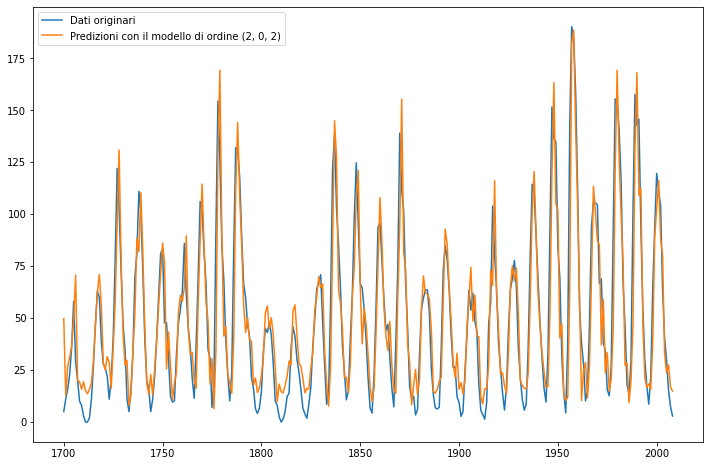

In [10]:
y_pred = model.predict()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df, label='Dati originari')
ax.plot(y_pred, label='Predizioni con il modello di ordine (2, 0, 2)')
ax.legend()

plt.show()

Notiamo che la predizione segue abbastanza fedelmente il valore della serie originaria. Per esercizio, proviamo a vedere cosa accade usando un valore di AR e di MA più alto, ovvero pari a 3.

In [11]:
model_h = ARIMA(df, order=(3, 0, 3)).fit()
model_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1304.056
Date:                Mon, 26 Jul 2021   AIC                           2624.112
Time:                        10:09:44   BIC                           2653.979
Sample:                             0   HQIC                          2636.053
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7462      3.721     13.367      0.000      42.452      57.040
ar.L1          0.8703      0.728      1.195      0.232      -0.557       2.297
ar.L2          0.0937      1.013      0.092      0.926      -1.892       2.080
ar.L3         -0.4273      0.525     -0.814      0.416      -1.456       0.602
ma.L1          0.4410      0.738      0.598      0.550      -1.004       1.887
ma.L2         -0.0034      0.133     -0.025      0.980      -0.265       0.258
ma.L3         -0.0070      0.141     -0.049      0.961      -0.284       0.270
sigma2       268.9651     19.091     14.089      0.000     231.548     306.382
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               110.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.93
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

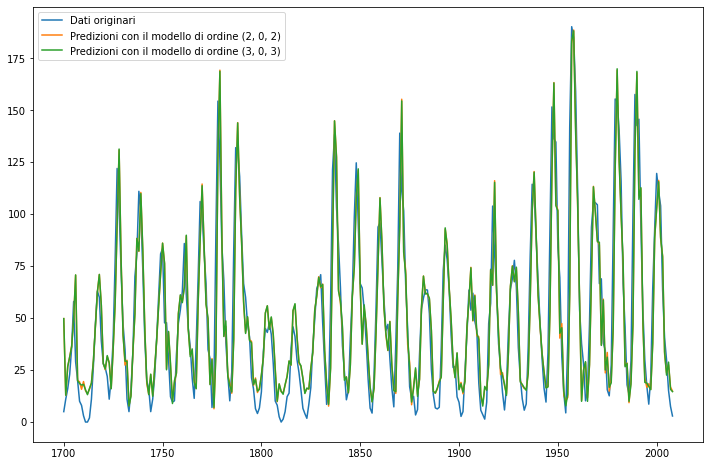

In [12]:
y_pred_h = model_h.predict()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df, label='Dati originari')
ax.plot(y_pred, label='Predizioni con il modello di ordine (2, 0, 2)')
ax.plot(y_pred_h, label='Predizioni con il modello di ordine (3, 0, 3)')
ax.legend()

plt.show()

Vediamo che i valori assunti dai due modelli sono quasi perfettamente sovrapponibili, per cui possiamo tranquillamente limitarci a scegliere il modello di ordine inferiore.



## Esercizio

Provate ad effettuare la decomposizione STL sul dataset sunspots, e la modellazione con ARIMA sul dataset CO2.